In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.probability import FreqDist
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer('russian')
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from pandarallel import pandarallel
import swifter

# Функции для обработки данных

Замена звёздочки в очевидном случае

In [2]:
def asterix_obvious_replace(text):
    phrases = text.split(', ')
    for i in range(len(phrases)):
        if 'здравствуйте меня * *' in phrases[i]:
            phrases[i] = phrases[i].replace('здравствуйте меня * *', 'здравствуйте меня зовут *')
        elif (i > 0) and ('меня * *' in phrases[i]):
            for j in range(i - 1, -1, -1):
                if phrases[j][0] == '1':
                    if (
                        phrases[j].split()[-1] == 'здравствуйте' or
                        (phrases[j].split()[-2] + ' ' +  phrases[j].split()[-1] == 'добрый вечер') or
                        (phrases[j].split()[-2] + ' ' +  phrases[j].split()[-1] == 'доброе утро') or
                        (phrases[j].split()[-2] + ' ' +  phrases[j].split()[-1] == 'добрый день')
                    ):
                        phrases[i] = phrases[i].replace('меня * *', 'меня зовут *')
                    break
    return ', '.join(phrases)

Замена повторяющихся слов

In [3]:
def change_repeating_words(text, set_of_symbols_wo_meaning):
    phrases = text.split(', ')
    for i in range(len(phrases)):
        words = phrases[i].split()
        j = 0
        new_string = ''
        while j < len(words):
            if (j != len(words) - 1) and (words[j] not in set_of_symbols_wo_meaning) and (words[j] == words[j + 1]):
                cur_word = words[j]
                j += 1
                while j < (len(words) - 1) and cur_word == words[j + 1]:
                    j += 1
                new_string += cur_word + ' '
                j += 1
            else:
                new_string += words[j] + ' '
                j += 1
        new_string = new_string[:-1]
        phrases[i] = new_string
    return ', '.join(phrases)

Откидываем кавычки

In [4]:
def cut_quotes(text):
    phrases = text.split(', ')
    for i in range(len(phrases)):
        if phrases[i][0] == "'":
            phrases[i] = phrases[i][1:]
        if phrases[i][-1] == "'":
            phrases[i] = phrases[i][:-1]
    return ', '.join(phrases)

Расставляем роли в разговоре

In [5]:
def set_missing_roles(text):
    phrases = text.split(', ')
    turn_now = -1
    for i in range(len(phrases)):
        if phrases[i][0] == '1':
            turn_now = 1
        elif phrases[i][0] == '0':
            turn_now = 0
        elif turn_now == -1:
            j = i
            while (j < len(phrases)) and (phrases[j][0] not in ('0', '1')):
                j += 1
            turn_now = int(phrases[j][0])
            if turn_now == 1:
                phrases[i] = '1 '+ phrases[i]
            else:
                phrases[i] = '0 ' + phrases[i]
        else:
            if turn_now == 1:
                phrases[i] = '1 '+ phrases[i]
            else:
                phrases[i] = '0 '+ phrases[i]
    return ', '.join(phrases)

Считаем количество переходов между ролями

In [6]:
def count_speaker_shifts(text):
    phrases = text.split(', ')
    shifts = 0
    for i in range(1, len(phrases)):
        if phrases[i][0] != phrases[i - 1][0]:
            shifts += 1
    return shifts

Функция для красивой распечатки диалогов

In [7]:
def phrases_print(text_list):
    for text in text_list:
        phrases = text.split(', ')
        for elem in phrases:
            if elem[0] == '1':
                print('Сотрудник КЦ:', elem[2:])
            else:
                print('Пользователь:', elem[2:])
        print('\n')

In [8]:
def cut_stop_words(words, stop_words):
    result_list = [x for x in words if x not in stop_words]
    return result_list

In [9]:
def stem_rus_words(words):
    temp_words = words.copy()
    for i in range(len(temp_words)):
        temp_words[i] = snowball.stem(temp_words[i])
    return temp_words

Оставляем фразы только одного говорящего

In [10]:
def leave_certain_phrases(text, indicator):
    words = text.split(', ')
    needed_phrases = []
    for elem in words:
        if elem[0] == str(indicator):
            needed_phrases.append(elem)
    return ', '.join(needed_phrases)

Печатаем частоту появления слов

In [11]:
def print_word_frequencies(results, df, stemmed = '', role = 'oper_', top_words = 40):
    for elem in results:
        result_words = []
        
        for item in df[df['results'] == elem][role + stemmed + 'words']:
            result_words = result_words + item
            
        print('Результат:', elem + ';',
              'Роль: ' + ('Оператор' if role == 'oper_' else 'Клиент') + ';',
              'Стемминг: ' + ('False' if stemmed == '' else 'True') + ';')
        plt.figure(figsize=(15, 5))
        FreqDist(result_words).plot(top_words)

Строим облако слов

In [12]:
def construct_word_cloud(df_column):
    result_words = []
    for elem in df_column:
        result_words = result_words + elem
        
    result_freqs = FreqDist(result_words) 
    
    wordcloud = WordCloud().generate_from_frequencies(result_freqs)
    plt.figure(figsize = (15, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Задаём словари стоп-слов

In [13]:
set_of_symbols_wo_meaning = {' ', '*', "'", ',', '!', '%', '?', '/', '0', '1', ''}

with open('stop_words_russian.txt', encoding='UTF-8') as f:
    lines = f.readlines()
for i in range(len(lines)):
    lines[i] = lines[i].split()[0]
    
stop_words_common = lines

stop_symbols = list(set_of_symbols_wo_meaning)

stop_words_custom = [
    'угу',
    'здравствуйте',
    'свидания',
    'доброго',
    'могу',
    'можете',
    'удобно',
    'зовут',
    'скажите',
    'поняла',
    'понял',
    'добрый',
    'ой',
    'вашей',
    'вашу',
    'давайте',
    'верно',
    'продиктуйте',
    'подскажите',
    'назовите',
    'представляю',
    'прослушать',
    'звоню',
    'обращаться',
    'извините',
    'уделите',
    'понимаю',
    'вашего',
    'фамилию',
    'заполним',
    'анкету',
    'минут',
    'прослушаете',
    'прослушайте',
    'заинтересует',
    'предлагаем',
    'предлагаю',
    'перезвонить',
    'слышно',
    'предложение',
    'предложением',
    'смотрите',
    'беспокойство',
    'прощения',
    'сможете',
    'ответить',
    'пару',
    'предложить',
    'получить',
    'попробуем',
    'отчество',
    'фамилия',
    'получены'
]

# Считывание данных

In [14]:
#df = pd.read_csv('tqm_msu_clean_data_v3.csv')
df = pd.read_csv('clean_data_1.csv')
df.head(5)

,filename,date,segment_id,phrases,ymd,hi_task_id,start_date,end_date,operator_user_id
0,7981686275_SegmentMP3_ts210601045153_t16803325...,2021-06-01,1.015675e+09,"['0 алло', '1 здравствуйте меня * * я звоню ва...",2021-06-01,9729733797#28323757694,2021-06-01 04:52:09,2021-06-01 04:52:23,410039.0
1,7982058552_SegmentMP3_ts210601063252_t16803939...,2021-06-01,1.015691e+09,['1 здравствуйте меня * * я звоню вам с выгодн...,2021-06-01,9731110508#28313347700,2021-06-01 06:33:10,2021-06-01 06:33:25,410039.0
2,7982514703_SegmentMP3_ts210601073352_t16804745...,2021-06-01,1.015712e+09,['1 здравствуйте меня * * для вас предложение ...,2021-06-01,9731246830#28334794705,2021-06-01 07:34:09,2021-06-01 07:34:35,445238.0
3,7986153932_SegmentMP3_ts210601100404_t16810963...,2021-06-01,1.015933e+09,"['0 *', '1 здравствуйте', '1 здравствуйте вы м...",2021-06-01,9730320464#28326001076,2021-06-01 10:04:18,2021-06-01 10:04:30,384483.0
4,7986301662_SegmentMP3_ts210601100758_t16811176...,2021-06-01,1.015942e+09,"['0 да', '1 здравствуйте меня * * я', '1 звоню...",2021-06-01,9722945070#28302473425,2021-06-01 10:08:26,2021-06-01 10:08:37,487211.0


In [15]:
df['phrases'] = df['phrases'].swifter.apply(lambda x: x[1:-1])
df['phrases'] = df['phrases'].swifter.apply(lambda x: x.replace('\n', ' '))
df.head(5)

Pandas Apply:   0%|          | 0/500000 [00:00<?, ?it/s]

,filename,date,segment_id,phrases,ymd,hi_task_id,start_date,end_date,operator_user_id
0,7981686275_SegmentMP3_ts210601045153_t16803325...,2021-06-01,1.015675e+09,"'0 алло', '1 здравствуйте меня * * я звоню вам...",2021-06-01,9729733797#28323757694,2021-06-01 04:52:09,2021-06-01 04:52:23,410039.0
1,7982058552_SegmentMP3_ts210601063252_t16803939...,2021-06-01,1.015691e+09,'1 здравствуйте меня * * я звоню вам с выгодны...,2021-06-01,9731110508#28313347700,2021-06-01 06:33:10,2021-06-01 06:33:25,410039.0
2,7982514703_SegmentMP3_ts210601073352_t16804745...,2021-06-01,1.015712e+09,'1 здравствуйте меня * * для вас предложение о...,2021-06-01,9731246830#28334794705,2021-06-01 07:34:09,2021-06-01 07:34:35,445238.0
3,7986153932_SegmentMP3_ts210601100404_t16810963...,2021-06-01,1.015933e+09,"'0 *', '1 здравствуйте', '1 здравствуйте вы ме...",2021-06-01,9730320464#28326001076,2021-06-01 10:04:18,2021-06-01 10:04:30,384483.0
4,7986301662_SegmentMP3_ts210601100758_t16811176...,2021-06-01,1.015942e+09,"'0 да', '1 здравствуйте меня * * я', '1 звоню ...",2021-06-01,9722945070#28302473425,2021-06-01 10:08:26,2021-06-01 10:08:37,487211.0


In [16]:
df = df[df['phrases'].swifter.apply(lambda x: 0 if len(set(x) & set_of_symbols_wo_meaning) == len(set(x)) else 1) == 1]
df['phrases'] = df['phrases'].swifter.apply(cut_quotes)
df['phrases'] = df['phrases'].swifter.apply(set_missing_roles)
df['phrases'] = df['phrases'].swifter.apply(lambda x: change_repeating_words(x, set_of_symbols_wo_meaning))
df['phrases'] = df['phrases'].swifter.apply(asterix_obvious_replace)
df['shifts'] = df['phrases'].swifter.apply(count_speaker_shifts)
df['oper_phrases'] = df['phrases'].swifter.apply(lambda x: leave_certain_phrases(x, 1))
df['cust_phrases'] = df['phrases'].swifter.apply(lambda x: leave_certain_phrases(x, 0))
df['oper_words'] = df['oper_phrases'].swifter.apply(word_tokenize)
df['cust_words'] = df['cust_phrases'].swifter.apply(word_tokenize)
df.head(5)

Pandas Apply:   0%|          | 0/500000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

,filename,date,segment_id,phrases,ymd,hi_task_id,start_date,end_date,operator_user_id,shifts,oper_phrases,cust_phrases,oper_words,cust_words
0,7981686275_SegmentMP3_ts210601045153_t16803325...,2021-06-01,1.015675e+09,"0 алло, 1 здравствуйте меня зовут * я звоню ва...",2021-06-01,9729733797#28323757694,2021-06-01 04:52:09,2021-06-01 04:52:23,410039.0,2,1 здравствуйте меня зовут * я звоню вам с выго...,"0 алло, 0 извините пожалуйста я на работе у ме...","[1, здравствуйте, меня, зовут, *, я, звоню, ва...","[0, алло, ,, 0, извините, пожалуйста, я, на, р..."
1,7982058552_SegmentMP3_ts210601063252_t16803939...,2021-06-01,1.015691e+09,1 здравствуйте меня зовут * я звоню вам с выго...,2021-06-01,9731110508#28313347700,2021-06-01 06:33:10,2021-06-01 06:33:25,410039.0,2,1 здравствуйте меня зовут * я звоню вам с выго...,"0 мне не интересно, 0 *","[1, здравствуйте, меня, зовут, *, я, звоню, ва...","[0, мне, не, интересно, ,, 0, *]"
2,7982514703_SegmentMP3_ts210601073352_t16804745...,2021-06-01,1.015712e+09,1 здравствуйте меня зовут * для вас предложени...,2021-06-01,9731246830#28334794705,2021-06-01 07:34:09,2021-06-01 07:34:35,445238.0,8,1 здравствуйте меня зовут * для вас предложени...,"0 алло, 0 нет не удобно, 0 потом перезвонят, 0 *","[1, здравствуйте, меня, зовут, *, для, вас, пр...","[0, алло, ,, 0, нет, не, удобно, ,, 0, потом, ..."
3,7986153932_SegmentMP3_ts210601100404_t16810963...,2021-06-01,1.015933e+09,"0 *, 1 здравствуйте, 1 здравствуйте вы меня сл...",2021-06-01,9730320464#28326001076,2021-06-01 10:04:18,2021-06-01 10:04:30,384483.0,1,"1 здравствуйте, 1 здравствуйте вы меня слышите...",0 *,"[1, здравствуйте, ,, 1, здравствуйте, вы, меня...","[0, *]"
4,7986301662_SegmentMP3_ts210601100758_t16811176...,2021-06-01,1.015942e+09,"0 да, 1 здравствуйте меня зовут * я, 1 звоню с...",2021-06-01,9722945070#28302473425,2021-06-01 10:08:26,2021-06-01 10:08:37,487211.0,2,"1 здравствуйте меня зовут * я, 1 звоню с банко...","0 да, 0 а девушка извините меня очень мало вре...","[1, здравствуйте, меня, зовут, *, я, ,, 1, зво...","[0, да, ,, 0, а, девушка, извините, меня, очен..."


In [17]:
df['oper_words'] = df['oper_words'].swifter.apply(lambda x: [y for y in x if y not in stop_words_common + stop_words_custom + stop_symbols])
df['cust_words'] = df['cust_words'].swifter.apply(lambda x: [y for y in x if y not in stop_words_common + stop_words_custom + stop_symbols])

df['oper_stemmed_words'] = df['oper_words'].swifter.apply(lambda x: [snowball.stem(y) for y in x])
df['cust_stemmed_words'] = df['cust_words'].swifter.apply(lambda x: [snowball.stem(y) for y in x])

df.head(5)

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/496910 [00:00<?, ?it/s]

,filename,date,segment_id,phrases,ymd,hi_task_id,start_date,end_date,operator_user_id,shifts,oper_phrases,cust_phrases,oper_words,cust_words,oper_stemmed_words,cust_stemmed_words
0,7981686275_SegmentMP3_ts210601045153_t16803325...,2021-06-01,1.015675e+09,"0 алло, 1 здравствуйте меня зовут * я звоню ва...",2021-06-01,9729733797#28323757694,2021-06-01 04:52:09,2021-06-01 04:52:23,410039.0,2,1 здравствуйте меня зовут * я звоню вам с выго...,"0 алло, 0 извините пожалуйста я на работе у ме...","[выгодным, банка, информацию]","[работе, никакие, выгодные, выгодные, предложе...","[выгодн, банк, информац]","[работ, никак, выгодн, выгодн, предложен, инте..."
1,7982058552_SegmentMP3_ts210601063252_t16803939...,2021-06-01,1.015691e+09,1 здравствуйте меня зовут * я звоню вам с выго...,2021-06-01,9731110508#28313347700,2021-06-01 06:33:10,2021-06-01 06:33:25,410039.0,2,1 здравствуйте меня зовут * я звоню вам с выго...,"0 мне не интересно, 0 *","[выгодным, банка, информацию, любом, случае, р...",[интересно],"[выгодн, банк, информац, люб, случа, разговор,...",[интересн]
2,7982514703_SegmentMP3_ts210601073352_t16804745...,2021-06-01,1.015712e+09,1 здравствуйте меня зовут * для вас предложени...,2021-06-01,9731246830#28334794705,2021-06-01 07:34:09,2021-06-01 07:34:35,445238.0,8,1 здравствуйте меня зовут * для вас предложени...,"0 алло, 0 нет не удобно, 0 потом перезвонят, 0 *","[банка, информацию, выгодным, банка, информаци...",[перезвонят],"[банк, информац, выгодн, банк, информац, удобн...",[перезвон]
3,7986153932_SegmentMP3_ts210601100404_t16810963...,2021-06-01,1.015933e+09,"0 *, 1 здравствуйте, 1 здравствуйте вы меня сл...",2021-06-01,9730320464#28326001076,2021-06-01 10:04:18,2021-06-01 10:04:30,384483.0,1,"1 здравствуйте, 1 здравствуйте вы меня слышите...",0 *,"[слышите, перезвоню]",[],"[слыш, перезвон]",[]
4,7986301662_SegmentMP3_ts210601100758_t16811176...,2021-06-01,1.015942e+09,"0 да, 1 здравствуйте меня зовут * я, 1 звоню с...",2021-06-01,9722945070#28302473425,2021-06-01 10:08:26,2021-06-01 10:08:37,487211.0,2,"1 здравствуйте меня зовут * я, 1 звоню с банко...","0 да, 0 а девушка извините меня очень мало вре...",[банковским],[девушка],[банковск],[девушк]


In [18]:
#Добавить считывание таргета в датафрейм и джойн с полученными результатами
df_target = pd.read_csv('msu_tqm_target.csv')
df_target['results'] = df_target['wo_hit_status_result_desc']
df_target = df_target[['segment_id', 'results']]

df = pd.merge(df, df_target, on='segment_id')
df.head(5)

,filename,date,segment_id,phrases,ymd,hi_task_id,start_date,end_date,operator_user_id,shifts,oper_phrases,cust_phrases,oper_words,cust_words,oper_stemmed_words,cust_stemmed_words,results
0,7981686275_SegmentMP3_ts210601045153_t16803325...,2021-06-01,1.015675e+09,"0 алло, 1 здравствуйте меня зовут * я звоню ва...",2021-06-01,9729733797#28323757694,2021-06-01 04:52:09,2021-06-01 04:52:23,410039.0,2,1 здравствуйте меня зовут * я звоню вам с выго...,"0 алло, 0 извините пожалуйста я на работе у ме...","[выгодным, банка, информацию]","[работе, никакие, выгодные, выгодные, предложе...","[выгодн, банк, информац]","[работ, никак, выгодн, выгодн, предложен, инте...","Дозвон, Отказ"
1,7982058552_SegmentMP3_ts210601063252_t16803939...,2021-06-01,1.015691e+09,1 здравствуйте меня зовут * я звоню вам с выго...,2021-06-01,9731110508#28313347700,2021-06-01 06:33:10,2021-06-01 06:33:25,410039.0,2,1 здравствуйте меня зовут * я звоню вам с выго...,"0 мне не интересно, 0 *","[выгодным, банка, информацию, любом, случае, р...",[интересно],"[выгодн, банк, информац, люб, случа, разговор,...",[интересн],"Дозвон, Отказ"
2,7982514703_SegmentMP3_ts210601073352_t16804745...,2021-06-01,1.015712e+09,1 здравствуйте меня зовут * для вас предложени...,2021-06-01,9731246830#28334794705,2021-06-01 07:34:09,2021-06-01 07:34:35,445238.0,8,1 здравствуйте меня зовут * для вас предложени...,"0 алло, 0 нет не удобно, 0 потом перезвонят, 0 *","[банка, информацию, выгодным, банка, информаци...",[перезвонят],"[банк, информац, выгодн, банк, информац, удобн...",[перезвон],"Дозвон, Перезвонить"
3,7986153932_SegmentMP3_ts210601100404_t16810963...,2021-06-01,1.015933e+09,"0 *, 1 здравствуйте, 1 здравствуйте вы меня сл...",2021-06-01,9730320464#28326001076,2021-06-01 10:04:18,2021-06-01 10:04:30,384483.0,1,"1 здравствуйте, 1 здравствуйте вы меня слышите...",0 *,"[слышите, перезвоню]",[],"[слыш, перезвон]",[],"Дозвон, Перезвонить"
4,7986301662_SegmentMP3_ts210601100758_t16811176...,2021-06-01,1.015942e+09,"0 да, 1 здравствуйте меня зовут * я, 1 звоню с...",2021-06-01,9722945070#28302473425,2021-06-01 10:08:26,2021-06-01 10:08:37,487211.0,2,"1 здравствуйте меня зовут * я, 1 звоню с банко...","0 да, 0 а девушка извините меня очень мало вре...",[банковским],[девушка],[банковск],[девушк],"Дозвон, Перезвонить"


In [20]:
df = df[['segment_id', 'hi_task_id', 'ymd', 'start_date', 'end_date', 'phrases', 
        'oper_phrases', 'cust_phrases', 'oper_words', 'cust_words', 'oper_stemmed_words', 'cust_stemmed_words', 'results']]
df.head(5)

,segment_id,hi_task_id,ymd,start_date,end_date,phrases,oper_phrases,cust_phrases,oper_words,cust_words,oper_stemmed_words,cust_stemmed_words,results
0,1.015675e+09,9729733797#28323757694,2021-06-01,2021-06-01 04:52:09,2021-06-01 04:52:23,"0 алло, 1 здравствуйте меня зовут * я звоню ва...",1 здравствуйте меня зовут * я звоню вам с выго...,"0 алло, 0 извините пожалуйста я на работе у ме...","[выгодным, банка, информацию]","[работе, никакие, выгодные, выгодные, предложе...","[выгодн, банк, информац]","[работ, никак, выгодн, выгодн, предложен, инте...","Дозвон, Отказ"
1,1.015691e+09,9731110508#28313347700,2021-06-01,2021-06-01 06:33:10,2021-06-01 06:33:25,1 здравствуйте меня зовут * я звоню вам с выго...,1 здравствуйте меня зовут * я звоню вам с выго...,"0 мне не интересно, 0 *","[выгодным, банка, информацию, любом, случае, р...",[интересно],"[выгодн, банк, информац, люб, случа, разговор,...",[интересн],"Дозвон, Отказ"
2,1.015712e+09,9731246830#28334794705,2021-06-01,2021-06-01 07:34:09,2021-06-01 07:34:35,1 здравствуйте меня зовут * для вас предложени...,1 здравствуйте меня зовут * для вас предложени...,"0 алло, 0 нет не удобно, 0 потом перезвонят, 0 *","[банка, информацию, выгодным, банка, информаци...",[перезвонят],"[банк, информац, выгодн, банк, информац, удобн...",[перезвон],"Дозвон, Перезвонить"
3,1.015933e+09,9730320464#28326001076,2021-06-01,2021-06-01 10:04:18,2021-06-01 10:04:30,"0 *, 1 здравствуйте, 1 здравствуйте вы меня сл...","1 здравствуйте, 1 здравствуйте вы меня слышите...",0 *,"[слышите, перезвоню]",[],"[слыш, перезвон]",[],"Дозвон, Перезвонить"
4,1.015942e+09,9722945070#28302473425,2021-06-01,2021-06-01 10:08:26,2021-06-01 10:08:37,"0 да, 1 здравствуйте меня зовут * я, 1 звоню с...","1 здравствуйте меня зовут * я, 1 звоню с банко...","0 да, 0 а девушка извините меня очень мало вре...",[банковским],[девушка],[банковск],[девушк],"Дозвон, Перезвонить"


In [21]:
df.to_csv('prepared_data.csv')

# Визуализация

Результат: Дозвон, Успешно; Роль: Оператор; Стемминг: False;


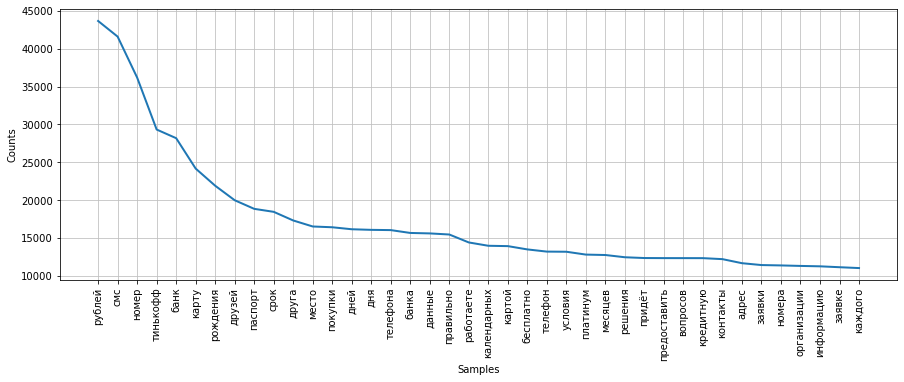

Результат: Дозвон, Отказ; Роль: Оператор; Стемминг: False;


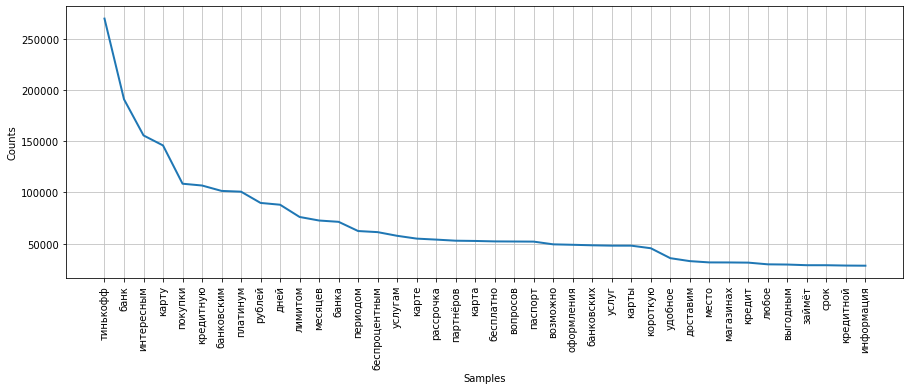

KeyboardInterrupt: 

In [245]:
results = [
    'Дозвон, Успешно',
    'Дозвон, Отказ',
    'Дозвон, Перезвонить',
    'Дозвон, Отложить'
]
        
print_word_frequencies(results, df
                      #, stemmed = 'stemmed_'
                      #, role = 'cust_'
                      #, top_words = 50
                      )

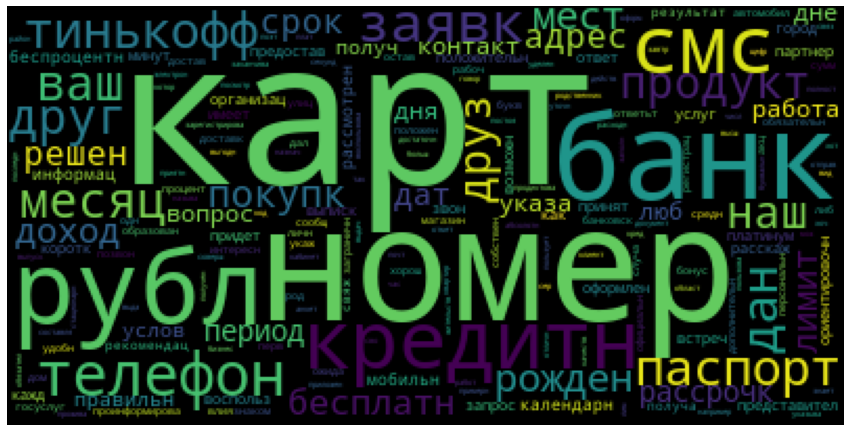

In [246]:
construct_word_cloud(df[df['results'] == 'Дозвон, Успешно']['oper_stemmed_words'])